### Data loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Team Blue NLP/train_cleaned.csv')
df.shape

(127656, 19)

In [3]:
# data[data['toxic']==1].shape

In [4]:
# # training data
# positive = data[data['toxic']==1]
# negative = data[data['toxic']==0].head(12500)
# df = pd.concat([positive, negative])
# df.shape

In [5]:
df.comment_cleaned_spell_no_stopwords_lemm = df.comment_cleaned_spell_no_stopwords_lemm.astype(str)

In [6]:
docs = df.comment_cleaned_spell_no_stopwords_lemm.values.tolist()
labels = df.toxic.values.tolist()

In [7]:
import numpy
labels = numpy.array(labels)

### Install Keras

In [ ]:
!pip install tensorflow keras

In [9]:
from numpy import array

In [10]:
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

### Tokenizing

In [11]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1 # number of words in corpus + 1

In [12]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
# print("Encoded docs:\n", encoded_docs)
type(encoded_docs)

list

Text(0.5, 1.0, 'Distribution of comments length (words)')

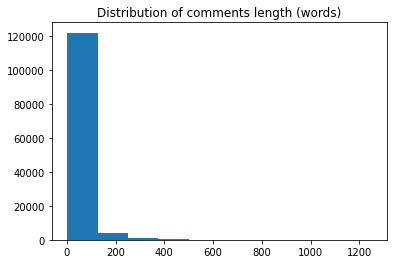

In [34]:
# check docs length
import matplotlib.pyplot as plt

plt.hist(list(map(lambda doc: len(doc), encoded_docs)));
plt.title("Distribution of comments length (words)")

In [14]:
# pad documents to a max length of 4 words
max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print("Padded docs:\n", padded_docs)

Padded docs:
 [[   50  8688  2278 ...     0     0     0]
 [   73    27  1346 ...     0     0     0]
 [   26  3236    45 ...     0     0     0]
 ...
 [    3   114  3326 ...     0     0     0]
 [  313 10181  5708 ...     0     0     0]
 [  159   168  2090 ...     0     0     0]]


### Loading the Glova

In [15]:
# load the whole embedding into memory
embeddings_index = dict()

In [16]:
# download and unzip the GloVe embeddings
!wget https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
!unzip glove6b100dtxt.zip 

--2022-12-14 03:11:38--  https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
Resolving dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)... 52.217.8.196, 52.216.233.27, 52.217.80.20, ...
Connecting to dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)|52.217.8.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137847651 (131M) [application/zip]
Saving to: ‘glove6b100dtxt.zip’

glove6b100dtxt.zip  100%[===================>] 131.46M  37.9MB/s    in 3.5s    

2022-12-14 03:11:42 (37.9 MB/s) - ‘glove6b100dtxt.zip’ saved [137847651/137847651]

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [17]:
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [18]:
# checking random word
embeddings_index["feel"]

array([-4.2895e-02,  7.0671e-01,  7.5316e-01, -5.9963e-01, -8.0169e-01,
        6.0094e-01, -6.7419e-01,  2.3592e-01,  2.4005e-01, -3.6372e-01,
       -2.2720e-01,  3.6026e-02,  4.6591e-01, -3.6233e-01, -3.1325e-01,
       -3.6757e-01, -5.7255e-01,  3.0661e-01, -4.8606e-01,  6.3214e-01,
        2.8931e-01,  6.0741e-01, -8.6788e-03, -6.8206e-01, -1.8410e-01,
        2.4847e-01,  9.5902e-02, -6.9108e-01,  9.0869e-01, -3.9224e-01,
        1.4345e-01,  7.8112e-01, -1.1601e-01,  6.0312e-02,  4.6300e-01,
       -4.4191e-02,  1.4284e-01,  6.2234e-01,  2.3943e-01, -4.6815e-01,
       -2.2553e-01, -3.1920e-01,  3.1397e-01, -4.2308e-01, -4.0827e-01,
       -2.4659e-01,  5.1572e-01,  3.5494e-01,  3.1545e-01, -1.4043e+00,
       -1.6486e-01, -5.5508e-02,  1.0260e-01,  6.1515e-01,  1.2691e-01,
       -2.2379e+00,  6.9510e-01,  1.2609e-01,  1.0901e+00,  2.5953e-01,
        2.2974e-01,  1.1125e+00, -1.0156e+00, -4.1881e-01,  3.8853e-01,
       -4.8856e-02,  9.1775e-01,  1.9732e-03, -6.9162e-01, -5.89

### Pre-Load the Weight Matrix

In [19]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100)) # create numpy ndarray equal to number of words*100
for word, i in t.word_index.items(): # list of unique words with index
    #print("Loading", word)
    embedding_vector = embeddings_index.get(word) # getting embedding matrix for words that the corpus have
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix.shape

(138467, 100)

### Running the model

In [21]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [22]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['ACC'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          13846700  
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 1)                 20001     
                                                                 
Total params: 13,866,701
Trainable params: 20,001
Non-trainable params: 13,846,700
_________________________________________________________________
None
Accuracy: 95.372719


### Testing the model

In [23]:
# # training data
# positive = data[data['toxic']==1].tail(1000)
# negative = data[data['toxic']==0].tail(4000)
# df_test = pd.concat([positive, negative])
# df_test.shape

In [24]:
df_test=pd.read_csv('/content/drive/MyDrive/Team Blue NLP/test_cleaned.csv')

In [25]:
df_test.comment_cleaned_spell_no_stopwords_lemm = df_test.comment_cleaned_spell_no_stopwords_lemm.astype(str)

In [26]:
docs_test = df_test.comment_cleaned_spell_no_stopwords_lemm.values.tolist()
labels_test = numpy.array(df_test.toxic.values.tolist())

In [27]:
encoded_docs_test = t.texts_to_sequences(docs_test) # encoding test data set
padded_test_docs = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post') # padding test data set

In [28]:
y_prob = model.predict(padded_test_docs)

998/998 [==============================] - 3s 3ms/step


In [29]:
y_pred = []
for i in range(len(y_prob)):
  if y_prob[i]>0.5:
    y_pred.append(1)
  else: 
    y_pred.append(0)

In [30]:
from sklearn.metrics import confusion_matrix 
confusion_matrix(labels_test, y_pred)

array([[28077,   779],
       [ 1467,  1592]])

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(labels_test, y_prob)

0.874082847652031

In [32]:
from sklearn.metrics import f1_score
f1_score(labels_test, y_pred)

0.5863720073664825

In [35]:
from sklearn.metrics import recall_score
recall_score(labels_test, y_pred)

0.5204315135665251

In [36]:
from sklearn.metrics import precision_score
precision_score(labels_test, y_pred)

0.6714466469843948